In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

In [49]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [50]:
train_dir = 'plant\Train\Train'
test_dir = 'plant\Test\Test'
validation_dir = 'plant\Validation\Validation'

In [51]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [52]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

Found 1322 images belonging to 3 classes.


In [53]:
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 60 images belonging to 3 classes.


In [54]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 150 images belonging to 3 classes.


In [55]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

In [56]:
def extract_features(generator, model):
    features = model.predict(generator)
    features = features.reshape((features.shape[0], -1))
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, model)
validation_features, validation_labels = extract_features(validation_generator, model)
test_features, test_labels = extract_features(test_generator, model)

X_train = np.concatenate((train_features, validation_features))
y_train = np.concatenate((train_labels, validation_labels))

# Train the SVM model with hyperparameter tuning
svm_model = SVC(kernel='linear', probability=True, C=1)
svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(test_features)
y_prob = svm_model.predict_proba(test_features)

print(classification_report(test_labels, y_pred, target_names=test_generator.class_indices.keys()))


c:\Users\srujan rai\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 199s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step
              precision    recall  f1-score   support

     Healthy       0.42      0.54      0.47        50
     Powdery       0.40      0.38      0.39        50
        Rust       0.34      0.26      0.30        50

    accuracy                           0.39       150
   macro avg       0.39      0.39      0.39       150
weighted avg       0.39      0.39      0.39       150



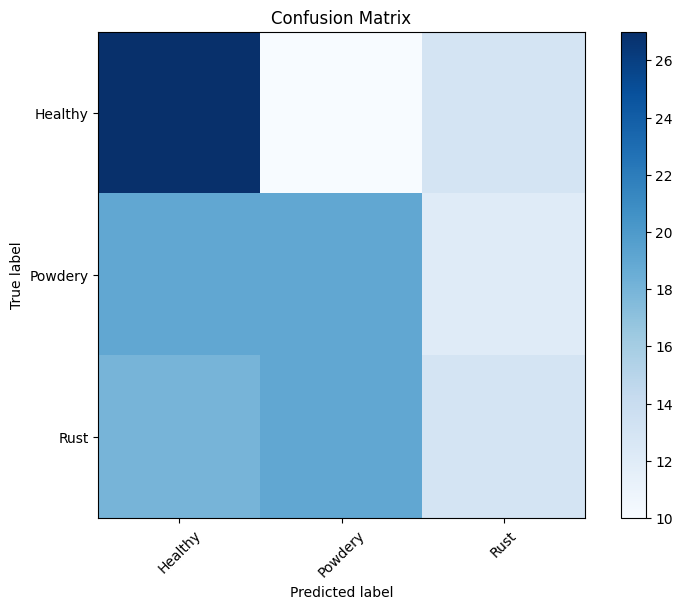

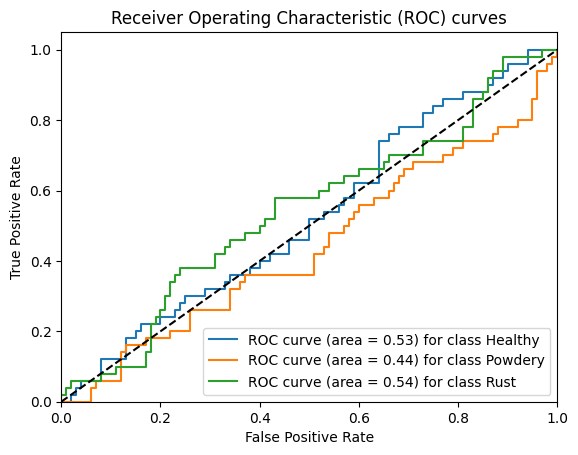

In [57]:
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(test_generator.class_indices)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {list(test_generator.class_indices.keys())[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves')
plt.legend(loc="lower right")
plt.show()

In [58]:
import joblib
model_filename = 'svm_model.joblib'
joblib.dump(svm_model, model_filename)
print(f'Model saved as {model_filename}')

Model saved as svm_model.joblib


In [64]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import joblib

# Constants
IMAGE_SIZE = (224, 224)

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_filename = 'svm_model.joblib'
svm_model = joblib.load(model_filename)

# Class indices (ensure these match the original training class indices)
class_indices = {
    'healthy': 0,
    'powdery': 1,
    'rust': 2
}

def predict_image(image_path, model, class_indices):
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = vgg16_model.predict(img_array)
    features = features.reshape((features.shape[0], -1))

    prediction = model.predict(features)
    prediction_prob = model.predict_proba(features)

    predicted_class = list(class_indices.keys())
    predicted_label = predicted_class[prediction[0]]
    confidence = prediction_prob[0][prediction[0]]

    return predicted_label, confidence

image_path = 'plant\Train\Train\Healthy\8c2bb1e6bc87329c.jpg'  
predicted_label, confidence = predict_image(image_path, svm_model, class_indices)
print(f'Predicted Label: {predicted_label}, Confidence: {confidence:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Predicted Label: healthy, Confidence: 0.36
